### Exploratory Data Analysis
* Distribution of Features per User
* Heatmap on User Pairs

In [334]:
import os
import sys
import glob
import datetime

import numpy as np
import scipy as sp
import pandas as pd

from ggplot import *
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl

%matplotlib inline

In [25]:
DATA_PATH = "/Users/beingzy/Documents/Projects/phd/data/"

#### Load Data

In [147]:
up_df = pd.read_csv(DATA_PATH + "user_profile.csv", header = 0, sep = ",")
up_df.set_index(["user_id"], inplace=True)

friends_df = pd.read_csv(DATA_PATH + "pairwise_friends.csv", header = 0, sep = ",")

udiff_df = pd.read_csv(DATA_PATH + "udiff_df.csv", header = 0, sep = ",")
udiff_df.set_index(["uid_a", "uid_b"], inplace=True)

print " ********************************* "
print " dimentions of users profile:"
print up_df.shape
print " ********************************* "
print " # of known friendship established: {0}".format(friends_df.shape[0])
print " ********************************* "
print " # of pair-wise profile difference created: {0}".format(udiff_df.shape[0])

 ********************************* 
 dimentions of users profile:
(3167, 27)
 ********************************* 
 # of known friendship established: 143846
 ********************************* 
 # of pair-wise profile difference created: 224264


#### Analyze missing data percentage per feature in User Profile Data (*up_df*)

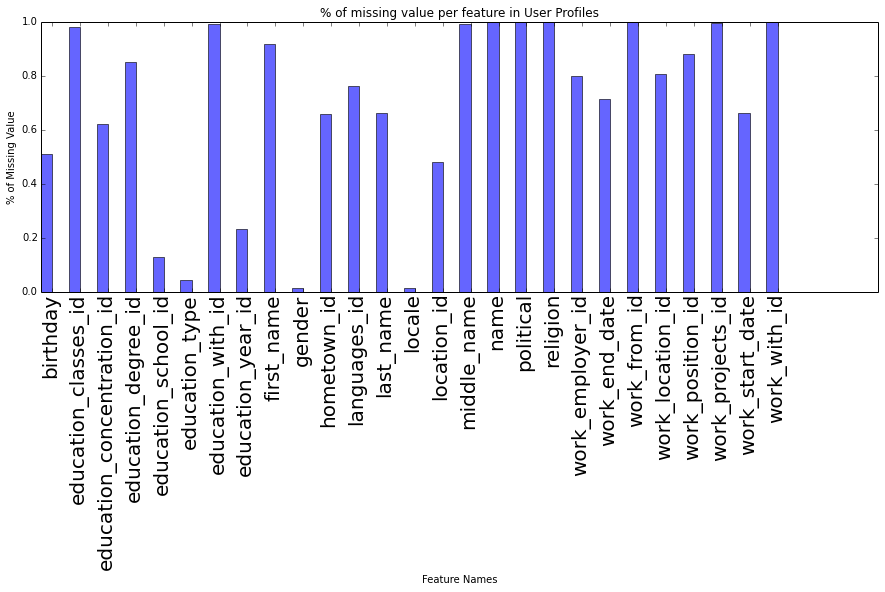

In [133]:
## ##########################################################    
## Count the number of missing values occuring in each feature
missing_cnt = []
missing_ptg = []
for col in up_df.columns:
    missing_cnt.append( sum(up_df[col].isnull()) )
    missing_ptg.append( sum(up_df[col].isnull()) * 1.0 / up_df.shape[0] )

## ##########################################################    
## plot bar chart to visualize the counts of missing value 
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

index = np.arange(len(missing_cnt))
bar_width = 0.4

plt.bar(index, missing_ptg, bar_width, color = 'b', alpha = .6)
plt.xlabel("Feature Names")
plt.ylabel("% of Missing Value")
plt.title("% of missing value per feature in User Profiles")
plt.xticks(index + bar_width, up_df.columns, rotation = 90, fontsize = 20)
plt.subplots_adjust(bottom = .15)

### Create the selection of features for analysis

In [283]:
in_feats = ["birthday", "education_concentration_id", "education_degree_id", "education_school_id", \
            "education_type", "education_year_id", "gender", "hometown_id", "languages_id", "locale", \
            "location_id", "work_employer_id", "work_end_date", "work_location_id", "work_position_id", \
            "work_start_date"]
in_feats.append("class")
#udiff_df["class"].unique()

### Summarize the Data Richness Per Observation

In [176]:
info_ptg = udiff_df[in_feats].notnull().sum(axis = 1) * 1.0 / len(in_feats)
info_ptg = pd.DataFrame(info_ptg, columns=["ptg"])

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.


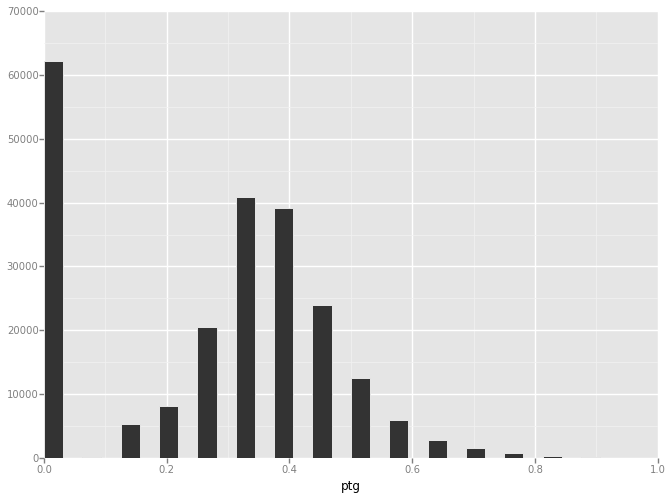

<ggplot: (285319885)>

In [175]:
## ################################### ##
## Visualize the histogram 
ggplot(aes(x = "ptg"), data = info_ptg) + geom_histogram()

According to the histogram shown above, the big portion of examples have zero information out of selected features.
**DECISION: Keep obervation with information percentage >= .2 **

In [190]:
print "# of observation of zero information: {}".format(sum(info_ptg["ptg"] == 0))

non_zero_obs_idx = [i for i, e in enumerate(info_ptg["ptg"]) if e >= 0.2]

# of observation of zero information: 62210


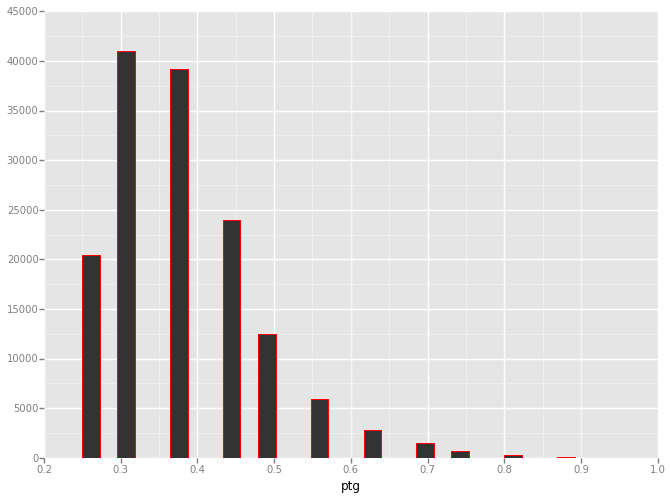

<ggplot: (286163077)>

In [191]:
## ################################### ##
## Visualize the histogram 
ggplot(aes(x = "ptg"), data = info_ptg.iloc[non_zero_obs_idx, :]) + geom_histogram(color = "red")

In [220]:
print udiff_df["class"].value_counts()
print "**********************************"
print udiff_df.ix[non_zero_obs_idx, "class"].value_counts()

1    143846
0     80418
dtype: int64
**********************************
1    102372
0     46110
dtype: int64


### Examine the distribution of every features group by class

In [354]:
## Genearte random samples from udiff_df
samp_idx = np.random.choice(range(udiff_df.shape[0]), size = 1000)
samples = udiff_df.ix[samp_idx, :]
samples["id"] = range(samples.shape[0])
## Reshape dataframe
melt_samples = pd.melt(samples, id_vars = ["id", "class"])
melt_samples = melt_samples.dropna()
print melt_samples.columns
melt_samples.head(5)

Index([u'id', u'class', u'variable', u'value'], dtype='object')


/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,class,variable,value
15,15,1,birthday,0
21,21,0,birthday,1
23,23,0,birthday,2
25,25,1,birthday,205
26,26,1,birthday,0


### Feature Transformation

Index([u'class', u'birthday', u'education_classes_id', u'education_concentration_id', u'education_degree_id', u'education_school_id', u'education_type', u'education_with_id', u'education_year_id', u'first_name', u'gender', u'hometown_id', u'languages_id', u'last_name', u'locale', u'location_id', u'middle_name', u'name', u'political', u'religion', u'work_employer_id', u'work_end_date', u'work_from_id', u'work_location_id', u'work_position_id', u'work_projects_id', u'work_start_date', u'work_with_id', u'id'], dtype='object')


### Clustering Analysis

In [387]:
from sklearn import cluster
from sklearn.preprocessing import Imputer

## define the data set for learning
df = udiff_df.copy()
## create selection of features
target_feat = "class"
all_feats = list(df.columns)

try:
    all_feats.remove("id")
except:
    pass
    
pred_feats = [col for col in all_feats if col !=  target_feat]
## split data into (x, y)
X = df[pred_feats]
y = df[target_feat]

## Mising Value Imputer
imp = Imputer(missing_values = "NaN", strategy="median", axis=0)
imp.fit(X)
## Impute missing value in X
X = imp.transform(X)

In [393]:
## define kmeans
inertias = []
durations = []
run_times = []

ks = np.arange(3, 40)

for k in ks:    
    print "Training cluster with pre-defined clusters: {0}".format(k)
    kmeans = cluster.KMeans(n_clusters=k)
    start_time_ = datetime.datetime.now()
    kmeans.fit(X)   
    duration_ = datetime.datetime.now() - start_time_
    print "Consumed time: {0} s".format(duration_.seconds)
    print "*******************************"
    run_times.append(duration_.seconds)
    inertias.append(kmeans.inertia_)

Training cluster with pre-defined clusters: 3
Cusumed time: 6 s
*******************************
Training cluster with pre-defined clusters: 4
Cusumed time: 5 s
*******************************
Training cluster with pre-defined clusters: 5
Cusumed time: 6 s
*******************************
Training cluster with pre-defined clusters: 6
Cusumed time: 7 s
*******************************
Training cluster with pre-defined clusters: 7
Cusumed time: 10 s
*******************************
Training cluster with pre-defined clusters: 8
Cusumed time: 9 s
*******************************
Training cluster with pre-defined clusters: 9
Cusumed time: 11 s
*******************************
Training cluster with pre-defined clusters: 10
Cusumed time: 12 s
*******************************
Training cluster with pre-defined clusters: 11
Cusumed time: 14 s
*******************************
Training cluster with pre-defined clusters: 12
Cusumed time: 14 s
*******************************
Training cluster with pre-define

ERROR! Session/line number was not unique in database. History logging moved to new session 280


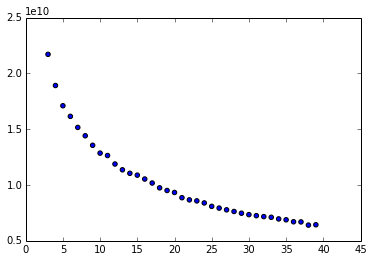

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


In [395]:
plt.scatter(ks, inertias)

In [398]:
#plt.plot(ks, run_times)
print run_times

[6, 5, 6, 7, 10, 9, 11, 12, 14, 14, 15, 18, 19, 19, 26, 22, 23, 24, 23, 27, 29, 29, 36, 27, 36, 37, 38, 42, 44, 54, 45, 48, 55, 65, 57, 54, 64]


### Visualize the pattern of high-dimensions with Heatmaps

In [231]:
print samples.head(5)

             birthday  education_concentration_id  education_degree_id  \
uid_a uid_b                                                              
1662  2798        NaN                         NaN                  NaN   
1399  1048          0                         NaN                  NaN   
1170  1742          0                         NaN                  NaN   
295   1291        NaN                         NaN                  NaN   
82    203           0                           2                  NaN   

             education_school_id  education_type  education_year_id  gender  \
uid_a uid_b                                                                   
1662  2798                   216               2                  3       1   
1399  1048                    63               0                NaN       0   
1170  1742                    11               0                  4       0   
295   1291                   488               0                  3       0   
82    2

In [286]:
#udiff_df[in_feats.append("class")]
#in_feats.append("class")
print in_feats
udiff_df[in_feats].to_csv(DATA_PATH + "udiff_selective.csv", sep = ",", \
                          header = True, index = True, index_label = ["ua_id", "ub_id"])

['birthday', 'education_concentration_id', 'education_degree_id', 'education_school_id', 'education_type', 'education_year_id', 'gender', 'hometown_id', 'languages_id', 'locale', 'location_id', 'work_employer_id', 'work_end_date', 'work_location_id', 'work_position_id', 'work_start_date', 'class']


/Applications/anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


.DS_Store          .ipynb_checkpoints data
.git               EDA_Facebook.ipynb data_vis.R
.gitignore         archives           images
